# Notebook Info
### Loading Data (colab)
* **need** to authenticate with google drive
* run all nodes upto data prep

### Loading Data (jupyter)
* dont import gdrive data loading packages
* skip setup and data loading section
* update choose dataset section to point at local files

## Imports

In [2]:
#set ranndomness for tensorflow model
import numpy as np
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
#general libraries
import os
import pandas as pd
import math as math

#neural network
import tensorflow.keras as keras

## GDrive Setup

In [ ]:
#gdrive data loading
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:
#authenticate google drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## GDrive Data loading

In [4]:
# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'1rpVjQD4ct5ddvGLbUUaYd0X9p8XPV1US' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)

title: BMIF3-FAT_DAILY.csv, id: 1yeofepBWSgKiRQ3mWSm9Di5nbas6V8yQ
downloading to /root/data/BMIF3-FAT_DAILY.csv
title: BMIF4_future_trends.csv, id: 1EHmKML2O8FqL414t77-0TmxYhfUvnHEL
downloading to /root/data/BMIF4_future_trends.csv
title: BMIF5_future_trends.csv, id: 1-U5JpzHxhNUYJc9Tcuy7p3qthmIz61EG
downloading to /root/data/BMIF5_future_trends.csv
title: BMIF5.csv, id: 1v5axnBAniBTAdmAlPsBR-YQWBL1LyoRJ
downloading to /root/data/BMIF5.csv
title: BMIF4.csv, id: 1NQCcoVK6i-TfSIQM8dnhveUqWaXHsMP2
downloading to /root/data/BMIF4.csv
title: BMIF1.csv, id: 1xiy-NG6YurNX7hh0ciqYBEZ0LLmMhskL
downloading to /root/data/BMIF1.csv
title: BMIF3.csv, id: 1QlIYBSJ8VNamT_QLExjzv5UvrWtFJKbl
downloading to /root/data/BMIF3.csv
title: BMIF2.csv, id: 1c6D7ZFx1qjZKI7MP-_0BAAQ2umQ7SjSM
downloading to /root/data/BMIF2.csv


### Choose dataset
- only run one cell below

In [5]:
df_raw = pd.read_csv("data/BMIF1.csv") # normal data with nothing special 

In [19]:
df_raw = pd.read_csv("data/BMIF2.csv") # updated day of year to days since first case
                                             # updated mandate columns to treat end period seperately (qualatative multinomial)

In [24]:
df_raw = pd.read_csv("data/BMIF3.csv") # BMIF2 + Fatality rate as target attribute

### Peek into data

In [6]:
print(df_raw.head())
print(df_raw.info())

  ﻿Country Name  Day of year  total_tests  active_cases  travel_limit  \
0   Afghanistan           35          0.0           0.0             0   
1   Afghanistan           36          0.0           0.0             0   
2   Afghanistan           37          0.0           0.0             0   
3   Afghanistan           38          0.0           0.0             0   
4   Afghanistan           39          0.0           0.0             0   

   stay_home  edu_fac_closed  any_gathering_restrict  any_business_closed  \
0          0               0                       0                    0   
1          0               0                       0                    0   
2          0               0                       0                    0   
3          0               0                       0                    0   
4          0               0                       0                    0   

   non-ess_business_closed  available_beds  
0                        0        0.013391  
1       

## Data prep

In [133]:
#df_date_col = pd.DataFrame(df_raw["date"].values)
#df_date_col.columns = ['date']
#df_raw.drop(['date'], axis=1, inplace=True)

df_raw.head()

,Day of year(first case),total_tests,active_cases,travel_limit,available_beds,stay_home,any_gathering_restrict,any_business_closed,educational_fac_closed,all_non-ess_business_closed,Iteration (#1),﻿Country Name,fatality_rate
0,-20,0.000000,0.000000,0,0.013391,0,0,0,0,0,0.0,Afghanistan,0.000000
1,-19,0.000000,0.000000,0,0.013391,0,0,0,0,0,0.0,Afghanistan,0.000000
2,-18,0.000000,0.000000,0,0.013391,0,0,0,0,0,0.0,Afghanistan,0.000000
3,-17,0.000000,0.000000,0,0.013391,0,0,0,0,0,0.0,Afghanistan,0.000000
4,-16,0.000000,0.000000,0,0.013391,0,0,0,0,0,0.0,Afghanistan,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,75,0.000132,0.000898,0,0.012149,0,1,1,1,0,0.0,Afghanistan,0.000158
96,76,0.000134,0.000979,0,0.012143,0,1,1,1,0,0.0,Afghanistan,0.000131
97,77,0.000135,0.001053,0,0.012139,0,1,1,1,0,0.0,Afghanistan,0.000053
98,78,0.000137,0.001111,0,0.012137,0,1,1,1,0,0.0,Afghanistan,0.000131


### Sliding Window
* only run to add sliding window
* one cell **creates method**
* second cell **creates window**
* not run for csv1 

In [26]:
def create_window(df_org,target_attr_name):
  df = df_org.copy() # operate on copy of frame
  df_raw_sliding_window = pd.DataFrame() # create empty output df

  for name,group in df.groupby('﻿Country Name'): # needs to be generated at country level
    #print(f"Generating sliding window for {name}")
    df_countrylevel = pd.DataFrame()

    target_attr_col = pd.DataFrame(group[target_attr_name].values)
    df_sliding_target_attr = pd.concat([target_attr_col.shift(5),target_attr_col.shift(4),
                                      target_attr_col.shift(3),target_attr_col.shift(2),
                                      target_attr_col.shift(1),target_attr_col], axis=1)
    df_sliding_target_attr.columns = ['t-5','t-4','t-3','t-2','t-1',target_attr_name]

    df_left = group.drop([target_attr_name], axis=1).reset_index(drop=True) #org df - target_attr
    df_countrylevel = pd.concat([df_left, df_sliding_target_attr], axis=1) # append sliding window column wise

    df_raw_sliding_window = pd.concat([df_raw_sliding_window,df_countrylevel], ignore_index=True) # append country level to out df row wise


  return df_raw_sliding_window.dropna(subset=['t-5','t-4','t-3','t-2','t-1'],inplace=False) # dropna and return


In [27]:
# only run cell to add sliding window
df_raw = create_window(df_raw, df_raw.columns[-1])

In [28]:
print(df_raw.head())
print(df_raw.info())

    Day of year(first case)  total_tests  active_cases  ...  t-2  t-1  fatality_rate
5                       -15     0.000000  0.000000e+00  ...  0.0  0.0            0.0
6                       -14     0.000000  0.000000e+00  ...  0.0  0.0            0.0
7                       -13     0.000000  0.000000e+00  ...  0.0  0.0            0.0
8                       -12     0.000000  0.000000e+00  ...  0.0  0.0            0.0
9                       -11     0.000000  0.000000e+00  ...  0.0  0.0            0.0
10                      -10     0.000000  0.000000e+00  ...  0.0  0.0            0.0
11                       -9     0.000000  0.000000e+00  ...  0.0  0.0            0.0
12                       -8     0.000000  0.000000e+00  ...  0.0  0.0            0.0
13                       -7     0.000000  0.000000e+00  ...  0.0  0.0            0.0
14                       -6     0.000000  0.000000e+00  ...  0.0  0.0            0.0
15                       -5     0.000000  0.000000e+00  ...  0.0 

### Data Splitting
* drops country
* splits df into features and labels
* uses sklearn.model_selection.train_test_split to generate training and test set

In [ ]:
from sklearn.model_selection import train_test_split

df_raw.drop(['﻿Country Name'], axis=1, inplace=True)

features = df_raw.iloc[:, 0:-1]
labels = df_raw.iloc[:, [-1]]
print(features)
print(labels)

x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=True, random_state=42)

x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)



In [20]:
print(f'train examples: {len(x_train)}')
print(f'test examples: {len(x_test)}')

train examples: 18036
test examples: 4509


## Models
* predictions from network saved as y_pred_[modelname]

In [12]:
# Linear Regression
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression(fit_intercept = False, n_jobs=-1)
linear_reg.fit(x_train, y_train)
y_pred_LR = linear_reg.predict(x_test)

In [13]:
# Random Forest
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(x_train, y_train)
y_pred_RF = rf.predict(x_test)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  import sys


In [31]:
# Neural Network - MLP
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html
from sklearn.neural_network import MLPRegressor

neural_MLP = MLPRegressor(random_state=42, max_iter=500)
neural_MLP.fit(x_train, y_train)
y_pred_MLP = neural_MLP.predict(x_test)


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Neural Network - LSTM
# Tensorflow imports
import tensorflow 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import r2_score

# method to wrap network setup into simple call
def init_LSTM(hidden_size, input_length, output_length, activation='relu', optimizer='adam', loss='mean_squared_error'):
  model = Sequential()
  model.add(LSTM(units=hidden_size, return_sequences=True, input_shape=(1, input_length)))
  model.add(LSTM(units=hidden_size, return_sequences=True))
  model.add(LSTM(units=hidden_size))
  model.add(Dense(units=output_length, activation=activation))
  model.compile(optimizer=optimizer, loss=loss)

  model.score=r2_score

  return model

# correct shape for tf
x_train_LSTM = np.reshape(x_train, (-1,1, x_train.shape[1]))
x_test_LSTM = np.reshape(x_test, (-1,1, x_test.shape[1]))

#same process as sklearn library
lstm_model = init_LSTM(50,x_train_LSTM.shape[2], y_train.shape[1])
lstm_model.fit(x_train_LSTM, y_train, epochs=30, batch_size=50, validation_split=.05,use_multiprocessing=True)
y_pred_LSTM = lstm_model.predict(x_test_LSTM,verbose=0,use_multiprocessing=True)

### Model Accuracy
* Will be used to compare above models based on ground truth and y_pred_[modelname]
* all models manipulate y by scaling output by 1000 (can be done as data was normalized by decimal scaling in KNIME)

In [12]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pylab

In [ ]:
# Linear Regression
y_test_shifted = y_test * 1000
y_pred_LR_shifted = y_pred_LR * 1000

# Statistical Measures
print(f'R squared: {linear_reg.score(x_test, y_test)}')
print() 
print('Mean squared error: %.2f'% mean_squared_error(y_test_shifted, y_pred_LR_shifted))
print('Root Mean squared error: %.2f'% mean_squared_error(y_test_shifted, y_pred_LR_shifted) ** 0.5)
print('Mean absolute error: %.2f'% mean_absolute_error(y_test_shifted, y_pred_LR_shifted)) 
print()

# Ground truth vs Predictions Scatter
x=range(len(x_test))
plt.scatter(x,y_test_shifted, label = 'Actual')
plt.scatter(x,y_pred_LR_shifted,label = 'Predicted')
plt.xlabel('Observations')
plt.legend()
plt.show()
print()

# Residual error plots
g=plt.plot(y_test_shifted - y_pred_LR_shifted,marker='o',linestyle='')
print()

# Ground truth vs Predictions Bar
df4 = pd.DataFrame({'Actual': y_test_shifted.flatten(), 'Predicted': y_pred_LR_shifted.flatten()})
df4
df5 = df4.head(50)
df5.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
# Random Forest
y_test_shifted = y_test * 1000
y_pred_RF_shifted = y_pred_RF * 1000

# Statistical Measures
print(f'R squared: {rf.score(x_test, y_test)}')
print() 
print('Mean squared error: %.2f'% mean_squared_error(y_test_shifted, y_pred_RF_shifted))
print('Root Mean squared error: %.2f'% mean_squared_error(y_test_shifted, y_pred_RF_shifted) ** 0.5)
print('Mean absolute error: %.2f'% mean_absolute_error(y_test_shifted, y_pred_RF_shifted))

# Ground truth vs Predictions Scatter
x=range(len(x_test))
plt.scatter(x,y_test_shifted, label = 'Actual')
plt.scatter(x,y_pred_RF_shifted,label = 'Predicted')
plt.xlabel('Observations')
plt.legend()
plt.show()
print()

# Residual error plots
g=plt.plot(y_test_shifted.flatten() - y_pred_RF_shifted.flatten(),marker='o',linestyle='')
print()

# Ground truth vs Predictions Bar
df4 = pd.DataFrame({'Actual': y_test_shifted.flatten(), 'Predicted': y_pred_RF_shifted.flatten()})
df4
df5 = df4.head(50)
df5.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [ ]:
# Multi-layer Perceptron Neural Network
y_test_shifted = y_test * 1000
y_pred_MLP_shifted = y_pred_MLP * 1000

# Statistical Measures
print(f'R squared: {neural_MLP.score(x_test, y_test)}')
print() 
print('Mean squared error: %.2f'% mean_squared_error(y_test_shifted, y_pred_MLP_shifted))
print('Root Mean squared error: %.2f'% mean_squared_error(y_test_shifted, y_pred_MLP_shifted) ** 0.5)
print('Mean absolute error: %.2f'% mean_absolute_error(y_test_shifted, y_pred_MLP_shifted))

# Ground truth vs Predictions Scatter
x=range(len(x_test))
plt.scatter(x,y_test_shifted, label = 'Actual')
plt.scatter(x,y_pred_MLP_shifted,label = 'Predicted')
plt.xlabel('Observations')
plt.legend()
plt.show()
print()

# Residual error plots
g=plt.plot(y_test_shifted.flatten() - y_pred_MLP_shifted.flatten(),marker='o',linestyle='')
print()

# Ground truth vs Predictions Bar
df4 = pd.DataFrame({'Actual': y_test_shifted.flatten(), 'Predicted': y_pred_MLP_shifted.flatten()})
df4
df5 = df4.head(50)
df5.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

R squared: 0.9935853271607126

Mean squared error: 1.41
Root Mean squared error: 1.19
Mean absolute error: 0.30
(-1018396.2843182898, -1021796.2307382263)


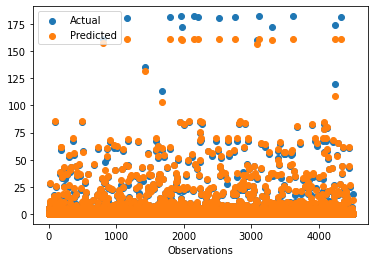

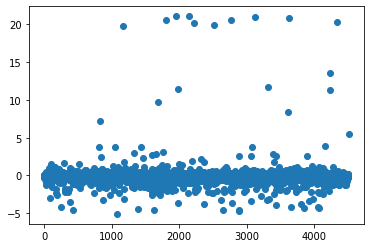

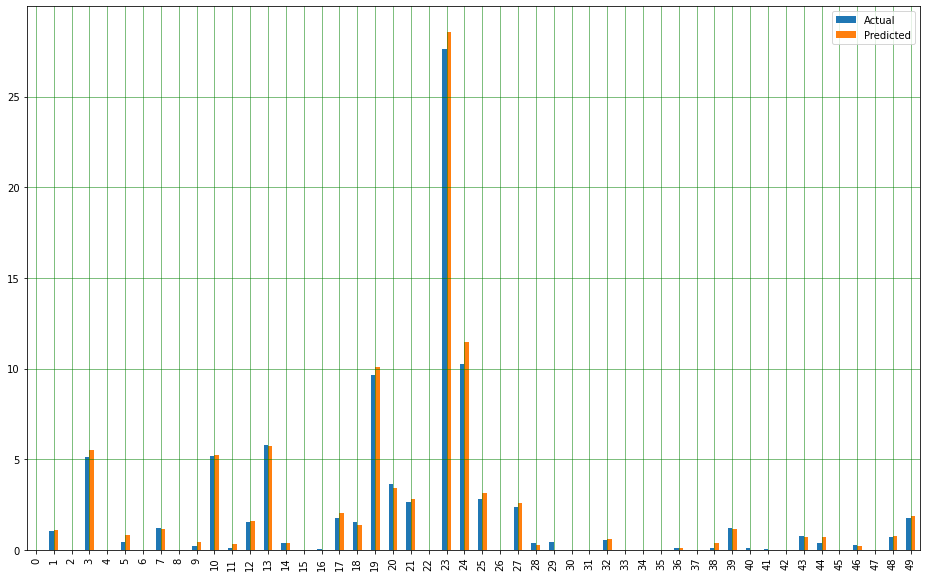

In [46]:
# Long Short-term Memory Neural Network
y_test_shifted = y_test * 1000
y_pred_LSTM_shifted = y_pred_LSTM * 1000

# Statistical Measures
print(f'R squared: {lstm_model.score(y_test_shifted, y_pred_LSTM_shifted)}')
print() 
print('Mean squared error: %.2f'% mean_squared_error(y_test_shifted, y_pred_LSTM_shifted))
print('Root Mean squared error: %.2f'% mean_squared_error(y_test_shifted, y_pred_LSTM_shifted) ** 0.5)
print('Mean absolute error: %.2f'% mean_absolute_error(y_test_shifted, y_pred_LSTM_shifted))

# Ground truth vs Predictions Scatter
x=range(len(x_test))
plt.scatter(x,y_test_shifted, label = 'Actual')
plt.scatter(x,y_pred_LSTM_shifted,label = 'Predicted')
plt.xlabel('Observations')
plt.legend()
plt.show()
print()

# Residual error plots
g=plt.plot(y_test_shifted - y_pred_LSTM_shifted,marker='o',linestyle='')
print()

# Ground truth vs Predictions Bar
df4 = pd.DataFrame({'Actual': y_test_shifted.flatten(), 'Predicted': y_pred_LSTM_shifted.flatten()})
df4
df5 = df4.head(50)
df5.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

### Feature Importance

In [22]:
# Linear Regression Feature Importance 
feat_imp = linear_reg.coef_.flatten()
columns = df_raw.columns
for i in range(15):
  print(f"{columns[i]}: {feat_imp[i]}") 

Day of year(first case): -4.185190795315903e-09
total_tests: -0.000715861271739492
active_cases: 0.002348658172925342
travel_limit: -4.489726216292279e-06
available_beds: 2.0586789003841952e-05
stay_home: -8.145798072978997e-07
any_gathering_restrict: 4.486295417317288e-06
any_business_closed: 3.7374024258992125e-06
educational_fac_closed: 3.2008225869578286e-07
all_non-ess_business_closed: 3.624919598576139e-06
t-5: 0.027963195926062268
t-4: -0.4279612645373682
t-3: 0.23166306539974957
t-2: -0.024599214793439052
t-1: 1.1930070462150788


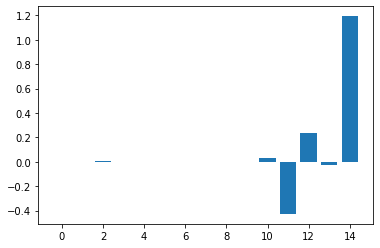

In [24]:
# Linear Regression Feature Importance Plot
plt.bar([x for x in range(len(feat_imp))], feat_imp)
plt.show()

In [27]:
# Random Forest Feature Importance
feat_imp = rf.feature_importances_.flatten()
columns = df_raw.columns
for i in range(15):
  print(f"{columns[i]}: {feat_imp[i]}") 

Day of year(first case): 0.0007724645248053082
total_tests: 0.0004588675915698965
active_cases: 0.0001953719665540194
travel_limit: 1.5640739494460845e-07
available_beds: 0.022393954016942635
stay_home: 1.3516445621112398e-06
any_gathering_restrict: 1.5263105102454666e-07
any_business_closed: 2.6348980383880213e-07
educational_fac_closed: 4.601321724470143e-07
all_non-ess_business_closed: 2.7783828777495056e-06
t-5: 0.021710268844833642
t-4: 0.03054912118917542
t-3: 0.036979466189745985
t-2: 0.061895476813633776
t-1: 0.8250398461748771


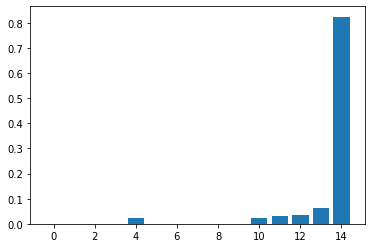

In [28]:
# Random Forest Feature Importance Plot
plt.bar([x for x in range(len(feat_imp))], feat_imp)
plt.show()

## When will Each Country run out of beds?
* future data analysis

### Data loading

In [ ]:
# load current data for training and future date for x_test
df_beds = pd.read_csv("data/BMIF2.csv") # beds as target attribute
df_beds_future = pd.read_csv("data/BMIF4_future_trends.csv") # future data (till start of November 2020)
df_beds = create_window(df_beds,'available_beds')
df_beds_future = create_window(df_beds_future,'available_beds')

df_fat = pd.read_csv("data/BMIF3.csv") # fatality rate as target attribute
df_fat_future = pd.read_csv("data/BMIF5_future_trends.csv")
df_fat = create_window(df_fat,'fatality_rate')
df_fat_future = create_window(df_fat_future,'fatality_rate')


#drop unneeded data, save country to reappend after
df_country_col = df_fat_future['﻿Country Name'].values
df_beds.drop(['﻿Country Name'], axis=1, inplace=True)
df_beds_future.drop(['﻿Country Name','available_beds'], axis=1, inplace=True)
df_fat.drop(['﻿Country Name'], axis=1, inplace=True)
df_fat_future.drop(['﻿Country Name','fatality_rate'], axis=1, inplace=True)


features = df_beds.iloc[:, 0:-1]
labels = df_beds.iloc[:, [-1]]
# ignore returned test sets and data split exactly the same way as above training
x_beds_train, _, y_beds_train, _ = train_test_split(features, labels, test_size=0.2, shuffle=True, random_state=42)
x_beds_train, y_beds_train = np.array(x_beds_train), np.array(y_beds_train)


features = df_fat.iloc[:, 0:-1]
labels = df_fat.iloc[:, [-1]]
x_fat_train, _, y_fat_train, _ = train_test_split(features, labels, test_size=0.2, shuffle=True, random_state=42)
x_fat_train, y_fat_train = np.array(x_fat_train), np.array(y_fat_train)


# future dataset is now our test data
x_beds_future = np.array(df_beds_future)
x_fat_future = np.array(df_fat_future)

#### Data Preview

In [ ]:
print(df_beds.info())
print(df_beds_future.info())
print(df_fat.info())
print(df_fat_future.info())

### Training

In [ ]:
# Linear Regression to predict future number of available beds trained on csv2 + sliding window
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
from sklearn.linear_model import LinearRegression

linear_reg_future = LinearRegression(fit_intercept = False, n_jobs=-1)
linear_reg_future.fit(x_beds_train, y_beds_train)
y_pred_beds_future = linear_reg_future.predict(x_beds_future)

In [ ]:
# update fatality future df and test set with available beds inserted at same pos as org dataset
beds_idx_pos = df_fat.columns.get_loc('available_beds')
df_fat_future.insert(loc=beds_idx_pos, column='available_beds', value=y_pred_beds_future)
df_fat_future.info()

x_fat_future = np.array(df_fat_future)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10716 entries, 5 to 11285
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Day of year(first case)      10716 non-null  int64  
 1   total_tests                  10716 non-null  float64
 2   active_cases                 10716 non-null  float64
 3   travel_limit                 10716 non-null  int64  
 4   available_beds               10716 non-null  float64
 5   stay_home                    10716 non-null  int64  
 6   any_gathering_restrict       10716 non-null  int64  
 7   any_business_closed          10716 non-null  int64  
 8   educational_fac_closed       10716 non-null  int64  
 9   all_non-ess_business_closed  10716 non-null  int64  
 10  t-5                          10716 non-null  float64
 11  t-4                          10716 non-null  float64
 12  t-3                          10716 non-null  float64
 13  t-2             

In [ ]:
# Linear Regression to predict future number of fatality rate trained on csv3 + sliding window
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
from sklearn.linear_model import LinearRegression

linear_reg_future = LinearRegression(fit_intercept = False, n_jobs=-1)
linear_reg_future.fit(x_fat_train, y_fat_train)
y_pred_fat_future = linear_reg_future.predict(x_fat_future)

### Data Export
* insert predictions and country into df
* save as csv for analysis in tableau

In [ ]:
df_fat_future.insert(loc=0, column='Country',value=df_country_col)
df_fat_future.insert(loc=len(df_fat_future.columns), column='fatality',value=y_pred_fat_future)

In [ ]:
print(df_fat_future.info())
df_fat_future.to_csv("data/future_predicted.csv",index=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10716 entries, 5 to 11285
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Country                      10716 non-null  object 
 1   Day of year(first case)      10716 non-null  int64  
 2   total_tests                  10716 non-null  float64
 3   active_cases                 10716 non-null  float64
 4   travel_limit                 10716 non-null  int64  
 5   available_beds               10716 non-null  float64
 6   stay_home                    10716 non-null  int64  
 7   any_gathering_restrict       10716 non-null  int64  
 8   any_business_closed          10716 non-null  int64  
 9   educational_fac_closed       10716 non-null  int64  
 10  all_non-ess_business_closed  10716 non-null  int64  
 11  t-5                          10716 non-null  float64
 12  t-4                          10716 non-null  float64
 13  t-3             